In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import random
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# --- Data Generator Class ---
class DataGenerator(Sequence):
    """
    Keras Data Generator for loading batches of .npz data efficiently.
    This class avoids loading all data into memory and processes batches on the fly.
    """

    def __init__(self, directory, batch_size=32, file_sample_ratio=0.1, sample_ratio=0.1, img_size=(256, 256), shuffle=True):
        super().__init__()
        self.directory = directory
        self.batch_size = batch_size
        self.file_sample_ratio = file_sample_ratio
        self.sample_ratio = sample_ratio
        self.img_size = img_size
        self.shuffle = shuffle
        self.npz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]

        # Sample a subset of files to manage large datasets
        num_files = len(self.npz_files)
        self.sampled_files = random.sample(self.npz_files, int(self.file_sample_ratio * num_files))
        self.filenames = [os.path.basename(f).split('.')[0] for f in self.sampled_files]

        if self.shuffle:
            random.shuffle(self.sampled_files)

        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.sampled_files) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        batch_files = self.sampled_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, bboxes, landmarks_2d, landmarks_3d = [], [], [], []
        for npz_file in batch_files:
            data = np.load(npz_file)
            color_images = data['colorImages']
            bboxes_data = data['boundingBox']
            landmarks2D_data = data['landmarks2D']
            landmarks3D_data = data['landmarks3D']

            # Sample a fraction of the frames
            num_frames = color_images.shape[-1]
            sampled_indices = random.sample(range(num_frames), int(self.sample_ratio * num_frames))

            for idx in sampled_indices:
                img = color_images[..., idx]
                img = cv2.resize(img, self.img_size)
                img = img / 255.0  # Normalize the image

                images.append(img)
                bboxes.append(bboxes_data[..., idx])
                landmarks_2d.append(landmarks2D_data[..., idx])
                landmarks_3d.append(landmarks3D_data[..., idx])

        # Convert to numpy arrays
        images = np.array(images)
        bboxes = np.array(bboxes)
        landmarks_2d = np.array(landmarks_2d)
        landmarks_3d = np.array(landmarks_3d)

        return images, images

    def on_epoch_end(self):
        """Shuffles the dataset at the end of each epoch if required."""
        if self.shuffle:
            random.shuffle(self.sampled_files)

In [4]:
# --- Preprocess Function ---
def preprocess_images(images):
    """
    Resize and normalize the images for input into the model.
    This function ensures all images are consistently processed.
    """
    processed_images = []
    for img_set in images:
        for img in img_set.transpose(2, 0, 1):
            img = cv2.resize(img, (256, 256))
            img = img / 255.0
            processed_images.append(img)
    return np.array(processed_images)

In [5]:
# --- Autoencoder Model ---
def build_autoencoder():
    """
    Build a Convolutional Autoencoder for image reconstruction.
    This model includes convolutional layers followed by max pooling and upsampling layers.
    """
    input_img = keras.Input(shape=(256, 256, 3))

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    return autoencoder

In [6]:
# --- Visualization Function ---
def display_comparison(original, reconstructed, names, n=5):
    """
    Display a side-by-side comparison of original and reconstructed images,
    including labels for each image.
    """
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title(f"Original: {names[i]}")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

In [7]:
# --- Save Comparisons Function ---
def save_comparisons(original, enhanced, names, folder="output"):
    """
    Save side-by-side comparisons of original and enhanced images to the specified folder,
    using the person's name as the filename.
    """
    os.makedirs(folder, exist_ok=True)
    for i in range(len(original)):
        original_img = (original[i] * 255).astype(np.uint8)
        enhanced_img = (enhanced[i] * 255).astype(np.uint8)
        combined = np.hstack((original_img, enhanced_img))  # Side-by-side comparison
        cv2.imwrite(os.path.join(folder, f"{names[i]}_comparison.png"), combined)

In [8]:
# --- Main Execution ---
# Set the dataset directory (update this path as necessary)
dataset_dir = 'dataset/'
train_generator = DataGenerator(directory=dataset_dir, batch_size=16, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(256, 256), shuffle=True)


In [9]:
# Build the autoencoder model
autoencoder = build_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Test generator to ensure it's working correctly
test_images, _ = train_generator[0]  # first batch
print(f"Loaded {test_images.shape[0]} images from the generator.")

Loaded 113 images from the generator.


In [11]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# --- Callbacks with Loss Capture ---
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])

loss_history = LossHistory()

In [14]:
# Callbacks for saving the best model and early stopping
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
for epoch in tqdm(range(20), desc="Training Progress"):
    try:
        history = autoencoder.fit(
            train_generator,
            validation_data=train_generator,
            epochs=1,
            callbacks=[model_checkpoint, early_stopping, loss_history]
        )
    except Exception as e:
        print(f"Error during training: {e}")
        break

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step - loss: 0.0711 - val_loss: 0.0429


Training Progress:   5%|▌         | 1/20 [01:38<31:03, 98.06s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 209s 34s/step - loss: 0.0375 - val_loss: 0.0289


Training Progress:  10%|█         | 2/20 [05:08<49:17, 164.33s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 183s 30s/step - loss: 0.0255 - val_loss: 0.0234


Training Progress:  15%|█▌        | 3/20 [08:14<49:17, 174.00s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 170s 25s/step - loss: 0.0233 - val_loss: 0.0188


Training Progress:  20%|██        | 4/20 [11:08<46:27, 174.20s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 118s 21s/step - loss: 0.0194 - val_loss: 0.0169


Training Progress:  25%|██▌       | 5/20 [13:10<38:49, 155.29s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 118s 21s/step - loss: 0.0153 - val_loss: 0.0153


Training Progress:  30%|███       | 6/20 [15:35<35:25, 151.80s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 99s 17s/step - loss: 0.0132 - val_loss: 0.0132


Training Progress:  35%|███▌      | 7/20 [17:17<29:22, 135.60s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 114s 16s/step - loss: 0.0125 - val_loss: 0.0105


Training Progress:  40%|████      | 8/20 [19:15<25:59, 129.93s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 12s/step - loss: 0.0107 - val_loss: 0.0101


Training Progress:  45%|████▌     | 9/20 [20:33<20:49, 113.62s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 134s 20s/step - loss: 0.0097 - val_loss: 0.0088


Training Progress:  50%|█████     | 10/20 [22:50<20:07, 120.78s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 101s 17s/step - loss: 0.0081 - val_loss: 0.0082


Training Progress:  55%|█████▌    | 11/20 [24:33<17:19, 115.47s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 110s 19s/step - loss: 0.0087 - val_loss: 0.0089


Training Progress:  60%|██████    | 12/20 [26:27<15:19, 114.97s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - loss: 0.0082 - val_loss: 0.0076


Training Progress:  65%|██████▌   | 13/20 [27:25<11:23, 97.68s/it] 

6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0082 - val_loss: 0.0073


Training Progress:  70%|███████   | 14/20 [28:01<07:54, 79.10s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 9s/step - loss: 0.0073 - val_loss: 0.0077


Training Progress:  75%|███████▌  | 15/20 [29:04<06:10, 74.18s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 8s/step - loss: 0.0070 - val_loss: 0.0065


Training Progress:  80%|████████  | 16/20 [30:00<04:34, 68.66s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.0064 - val_loss: 0.0064


Training Progress:  85%|████████▌ | 17/20 [30:55<03:14, 64.76s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - loss: 0.0062 - val_loss: 0.0063


Training Progress:  90%|█████████ | 18/20 [31:52<02:04, 62.40s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0064 - val_loss: 0.0057


Training Progress:  95%|█████████▌| 19/20 [32:37<00:57, 57.02s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - loss: 0.0061 - val_loss: 0.0061


Training Progress: 100%|██████████| 20/20 [34:02<00:00, 102.14s/it]


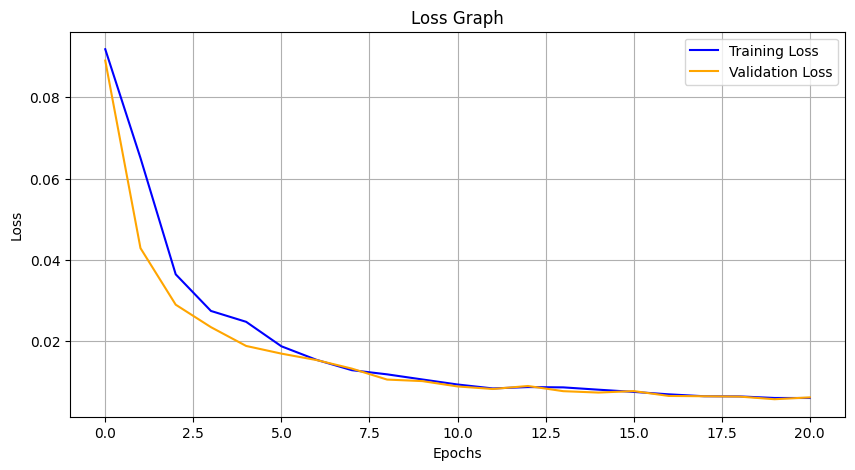

In [15]:
# --- Plot Loss Graph ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


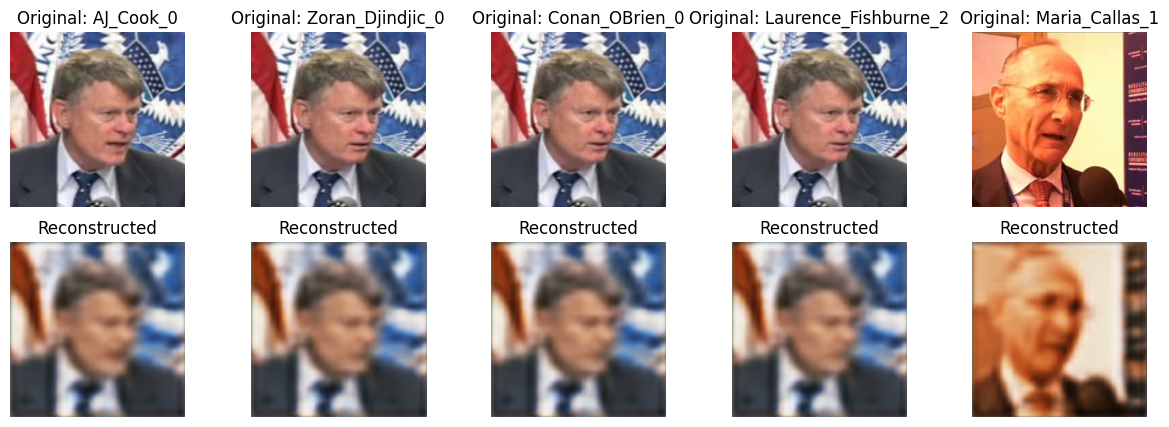

In [16]:
# Generate enhanced images from the validation set
original_images, _ = train_generator[0]  # Fetch the first batch of original images
reconstructed_images = autoencoder.predict(original_images[:5])  # Predicting on first 5 samples

names = train_generator.filenames[:5]

# Display a comparison between original and enhanced images
display_comparison(original_images[:5], reconstructed_images, names, n=5)

In [18]:
# --- Create Predictions Table ---
predictions_df = pd.DataFrame({
    'Filename': train_generator.filenames[:5],
    'Original': [original_images[i] for i in range(5)],
    'Reconstructed': [reconstructed_images[i] for i in range(5)]
})

# Display predictions table
print(predictions_df)

               Filename                                           Original  \
0             AJ_Cook_0  [[[0.596078431372549, 0.10196078431372549, 0.1...   
1      Zoran_Djindjic_0  [[[0.6, 0.10980392156862745, 0.125490196078431...   
2        Conan_OBrien_0  [[[0.6196078431372549, 0.10980392156862745, 0....   
3  Laurence_Fishburne_2  [[[0.6196078431372549, 0.10980392156862745, 0....   
4        Maria_Callas_1  [[[0.596078431372549, 0.45098039215686275, 0.2...   

                                       Reconstructed  
0  [[[0.36934194, 0.38282302, 0.39337555], [0.299...  
1  [[[0.3692466, 0.3826181, 0.39308953], [0.29941...  
2  [[[0.36870497, 0.3821564, 0.39236528], [0.2984...  
3  [[[0.3681591, 0.3816007, 0.3918966], [0.297590...  
4  [[[0.45316473, 0.4746451, 0.46936786], [0.4457...  


In [20]:
# --- Calculate Performance Metrics ---
mse = mean_squared_error(original_images[:5].reshape(-1, 256 * 256 * 3), reconstructed_images.reshape(-1, 256 * 256 * 3)) 
psnr_value = psnr(original_images[:5], reconstructed_images, data_range=1.0)

# --- Create Performance Metrics Table ---
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Peak Signal-to-Noise Ratio (PSNR)'],
    'Value': [mse, psnr_value]
})

# Display performance metrics table
print(metrics_df)

                              Metric      Value
0           Mean Squared Error (MSE)   0.011097
1  Peak Signal-to-Noise Ratio (PSNR)  19.548081


In [23]:
# Save the model after training
autoencoder.save("models/final_model.keras")

In [25]:
# Save comparisons for evaluation using person's name as filename
save_comparisons(original_images[:5], reconstructed_images, names)